Part I:

I spent ~4 hours on this, mostly getting the data into a form that could be fed into the models. I wound up spending about an hour trying to replicate a pandas built-in function, which is always a proud moment. 

Since all our data is categorical, we wind up with a very wide, pretty sparse data matrix. I chose 3 different classifiers to see if we could use the skill data to predict position title, Random Forest was a slight winner. Ensemble methods (like RF) tend to do the best with weak data. 

I didn't play around with feature engineering or using the timestamps to build time series, mostly due to time constraints. Also, using the time hacks to chop up the data into smaller chunks would have made the data even wider relative to depth for each time hack. Looking at these features is when correlations and trends emerge. 

I'd like to try a Hidden Markov Model on the skill data to see if we can identify latent sets within clusters. There might be sub-specialities we can identify either within or across skillsets.


In [1]:
import pandas as pd
import numpy as np
import string
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF

import matplotlib.pyplot as plt
%matplotlib inline 

In [16]:
df_raw = pd.read_json('data.json')

In [17]:
df_raw.head()

,company,position,skills,timeStamp
0,company_I,position_D,"[I, M, R, X, G, J, H, Q, X, L, T, Z, S, P, U, ...",4/2/2016
1,company_L,position_D,"[T, J, U, V, K, Z, L, C, C, T, K, T, W, P, S, ...",3/25/2016
2,company_C,position_C,"[P, U, U, J, S, X, L, L, N, R, Z, S, K, M, A, ...",1/19/2016
3,company_M,position_E,"[B, F, M, U, X, G, X, Q]",1/26/2016
4,company_K,position_C,"[W, B, D, A, R, U, X, G, V, B, W, B, Y, Y, L, ...",5/17/2016


In [10]:
df_raw['skills'] = df_raw['skills'].apply(lambda x: (set(x)))

In [18]:
df_skills = df_raw['skills']

In [19]:
df_skills.head()

0    [I, M, R, X, G, J, H, Q, X, L, T, Z, S, P, U, ...
1    [T, J, U, V, K, Z, L, C, C, T, K, T, W, P, S, ...
2    [P, U, U, J, S, X, L, L, N, R, Z, S, K, M, A, ...
3                             [B, F, M, U, X, G, X, Q]
4    [W, B, D, A, R, U, X, G, V, B, W, B, Y, Y, L, ...
Name: skills, dtype: object

In [20]:
test = pd.get_dummies(df_skills.apply(pd.Series).stack()).sum(level=0)

In [24]:
test.head(1)

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
0,0,0,1,0,0,0,1,1,1,1,...,3,1,1,1,1,0,2,2,0,2


In [26]:
test2 = pd.get_dummies(df_raw['skills'].apply(pd.Series).stack()).sum(level=0)

In [27]:
test2.head(1)

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
0,0,0,1,0,0,0,1,1,1,1,...,3,1,1,1,1,0,2,2,0,2


In [25]:
df_skills[0]

[u'I',
 u'M',
 u'R',
 u'X',
 u'G',
 u'J',
 u'H',
 u'Q',
 u'X',
 u'L',
 u'T',
 u'Z',
 u'S',
 u'P',
 u'U',
 u'N',
 u'N',
 u'Z',
 u'Q',
 u'W',
 u'W',
 u'Q',
 u'C']

In [28]:
# can't use pre-built 'get_dummies' because skills is a nested list

# I am assuming the possible skills are all letters A-Z, so I am using the string library
# to build the possible skills options. Otherwise I would walk through the column and manually
# build a dictionary using df.['skills'].tolist() or df['skills'].unique()

# the dataframe name is hardcoded here
def skill_profiler(row, skl_list):
    for i in skl_list:
        j = 'skill_' + i
        df_raw.loc[row,j] = 1
    pass

skill_list = string.ascii_uppercase

In [29]:
# going to use these column lists later to build analysis data matrices
skill_columns = []

for i in skill_list:
    name = 'skill_' + i
    df_raw[name] = 0
    skill_columns.append(name)
    

In [30]:
company_columns = df_raw['company'].unique()
position_columns = df_raw['position'].unique()

In [31]:
# takes a few seconds to run, my skill_profiler is slow

row = 0
for x in df_raw['skills']:
    skill_profiler(row,x)
    row +=1

In [8]:
df_raw.head()

,company,position,skills,timeStamp,skill_A,skill_B,skill_C,skill_D,skill_E,skill_F,...,skill_Q,skill_R,skill_S,skill_T,skill_U,skill_V,skill_W,skill_X,skill_Y,skill_Z
0,company_I,position_D,"set([C, G, I, H, J, M, L, N, Q, P, S, R, U, T,...",4/2/2016,0,0,1,0,0,0,...,1,1,1,1,1,0,1,1,0,1
1,company_L,position_D,"set([C, D, G, H, K, J, L, Q, P, S, U, T, W, V,...",3/25/2016,0,0,1,1,0,0,...,1,0,1,1,1,1,1,0,0,1
2,company_C,position_C,"set([A, K, J, M, L, N, P, S, R, U, W, X, Z])",1/19/2016,1,0,0,0,0,0,...,0,1,1,0,1,0,1,1,0,1
3,company_M,position_E,"set([B, G, F, M, Q, U, X])",1/26/2016,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,0
4,company_K,position_C,"set([A, B, E, D, G, L, R, U, T, W, V, Y, X])",5/17/2016,1,1,0,1,1,0,...,0,1,0,1,1,1,1,1,1,0


In [32]:
df_position = pd.get_dummies(df_raw['position'])
df_company = pd.get_dummies(df_raw['company'])


In [33]:
df1 = pd.concat([df_raw, df_position], axis=1)
df = pd.concat([df1, df_company], axis=1)

In [ ]:
# we keep the categorical columns so we have easy labels for our models

In [45]:
# data is now ready to analyze!
# since all these values are all unit binary (0 or 1), we don't need to scale or normalize them

# splitting into test / train sets

test_idx = np.random.uniform(0, 1, len(df)) <= 0.3
train = df[test_idx==False]
test = df[test_idx==True]

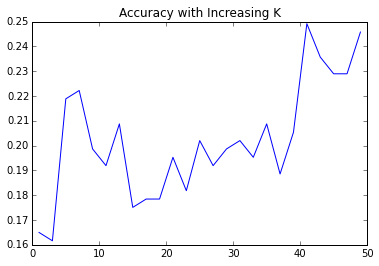

Best Accuracy: 0.249158, Neighbors: 41


In [120]:
# switch over to Manhattan distance

# lets use skills to predict position title

# first we're going to look at an elbow plot to find our optimum k

# The model is weak enough that we don't get a clean elbow. Using the nearest point seems most 
# effective

features = skill_columns
target = 'position'

# we want to remove one instance from a categorical value to reduce colinearity. 
features.pop()

results = []
for n in range(1, 51, 2):
    clf = KNN(n_neighbors=n, metric='euclidean')
    clf.fit(train[features], train[target])
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test[target], 1, 0).sum() / float(len(test))
#    print "Neighbors: %d, Accuracy: %3f" % (n, accuracy)
    results.append([n, accuracy])
        
results = pd.DataFrame(results, columns=["n", "accuracy"])

plt.plot(results.n, results.accuracy)
plt.title("Accuracy with Increasing K")
plt.show()

best = results.iloc[results['accuracy'].idxmax()]

print "Best Accuracy: %3f, Neighbors: %d" % (best['accuracy'],best['n'])


In [79]:
# let's try the same thing with Logistic Regression

clf = LR()
clf.fit(train[features], train[target])
preds = clf.predict(test[features])
accuracy = np.where(preds==test[target], 1, 0).sum() / float(len(test))
print "Accuracy: %3f" % (accuracy)
        


Accuracy: 0.195286


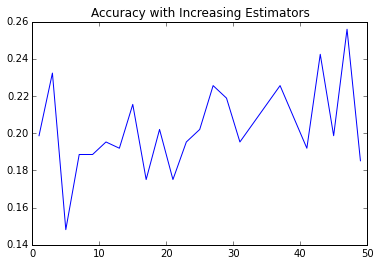

Best Accuracy: 0.255892, Estimators: 47


In [78]:
results = []
for n in range(1, 51, 2):
    clf = RF(n_estimators=n)
    clf.fit(train[features], train[target])
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test[target], 1, 0).sum() / float(len(test))
    results.append([n, accuracy])
        
results = pd.DataFrame(results, columns=["n", "accuracy"])

plt.plot(results.n, results.accuracy)
plt.title("Accuracy with Increasing Estimators")
plt.show()

best = results.iloc[results['accuracy'].idxmax()]

print "Best Accuracy: %3f, Estimators: %d" % (best['accuracy'],best['n'])


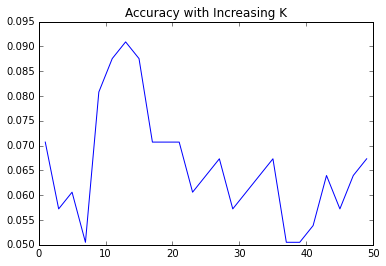

Best Accuracy: 0.090909, Neighbors: 13


In [81]:
# Let's see if we can do better predicting what companies have certain skill sets

features = skill_columns
target = 'company'

# we want to remove one instance from a categorical value to reduce colinearity. 
features.pop()

results = []
for n in range(1, 51, 2):
    clf = KNN(n_neighbors=n)
    clf.fit(train[features], train[target])
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test[target], 1, 0).sum() / float(len(test))
#    print "Neighbors: %d, Accuracy: %3f" % (n, accuracy)
    results.append([n, accuracy])
        
results = pd.DataFrame(results, columns=["n", "accuracy"])

plt.plot(results.n, results.accuracy)
plt.title("Accuracy with Increasing K")
plt.show()

best = results.iloc[results['accuracy'].idxmax()]

print "Best Accuracy: %3f, Neighbors: %d" % (best['accuracy'],best['n'])

In [82]:
clf = LR()
clf.fit(train[features], train[target])
preds = clf.predict(test[features])
accuracy = np.where(preds==test[target], 1, 0).sum() / float(len(test))
print "Accuracy: %3f" % (accuracy)
        

Accuracy: 0.057239


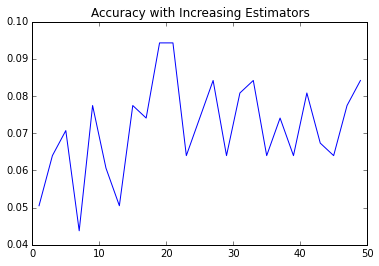

Best Accuracy: 0.094276, Estimators: 19


In [83]:
results = []
for n in range(1, 51, 2):
    clf = RF(n_estimators=n)
    clf.fit(train[features], train[target])
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test[target], 1, 0).sum() / float(len(test))
    results.append([n, accuracy])
        
results = pd.DataFrame(results, columns=["n", "accuracy"])

plt.plot(results.n, results.accuracy)
plt.title("Accuracy with Increasing Estimators")
plt.show()

best = results.iloc[results['accuracy'].idxmax()]

print "Best Accuracy: %3f, Estimators: %d" % (best['accuracy'],best['n'])


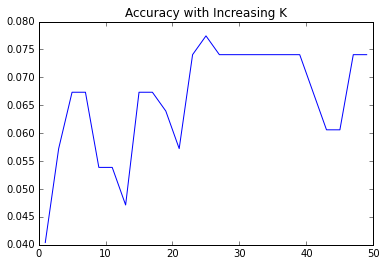

Best Accuracy: 0.077441, Neighbors: 25


In [93]:
# Can we predict company given position title? 

features = position_columns
target = 'company'

# we want to remove one instance from a categorical value to reduce colinearity. 
features = np.delete(features,1)

results = []
for n in range(1, 51, 2):
    clf = KNN(n_neighbors=n)
    clf.fit(train[features], train[target])
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test[target], 1, 0).sum() / float(len(test))
#    print "Neighbors: %d, Accuracy: %3f" % (n, accuracy)
    results.append([n, accuracy])
        
results = pd.DataFrame(results, columns=["n", "accuracy"])

plt.plot(results.n, results.accuracy)
plt.title("Accuracy with Increasing K")
plt.show()

best = results.iloc[results['accuracy'].idxmax()]

print "Best Accuracy: %3f, Neighbors: %d" % (best['accuracy'],best['n'])

Part II:

IBM Bluemix has a little more fine-grained categories, so I used their system instead of SentiWords. The back end relies on the LIWC psycho-linguistics dictionary, which is a bit more current.

I'm also trusting you guys with my twitter login details.

Key conclusion: very little of the tweets about the SuperBowl talk about football. The halftime show appears to have been far more interesting. Also, people were more conscientious than I would have expected for twitter. It's nice when the interne surprises you by being decent. 


In [102]:
from twitter import *
from watson_developer_cloud import ToneAnalyzerV2Experimental as ToneAnalyzer

token = '3145793684-SSH0g11QPD9Y2LhbmAwe4GS0Uwx8PPeoEFscOxs'
token_key = 'RrYvFsdAfOu2Me7S1clPbvYVjNU3w9CgsQT7tr9wzBB6u'
con_secret = 'HAsKOyBnzE1ReSAt1zf2FOs8z'
con_secret_key = 'kTTtphNZHDP9rNgxi97UZvWVDS0UPZUAZBKj0nzMNB6143EzuD'

t = Twitter(
auth=OAuth(token, token_key, con_secret, con_secret_key))


In [118]:
super_tweets = t.search.tweets(q="SuperBowl")
tweet_text = []
for i in super_tweets['statuses']:
    tweet_text.append(i['text'])
#print tweet_text

In [116]:
columns = [u'Cheerful', u'Negative', u'Angry',\
           u'Analytical', u'Confident', u'Tentative',\
           u'Open', u'Agreeable', u'Conscientious']

tone_analyzer = ToneAnalyzer(username="6d0c7680-2f8c-4151-ad33-21b464bff36a",
                             password="w9HbG6dV2jJj")

In [117]:
input_text = ' '.join(tweet_text)

tone_data = []
input_result = tone_analyzer.tone(text=input_text)
for i in input_result['children']:
    for j in i['children']:
        tone_data.append(j['raw_score'])

print " Tone of SuperBowl Tweets:"
df_tone = pd.DataFrame([tone_data], columns=columns)
df_tone.head()

 Tone of SuperBowl Tweets:


,Cheerful,Negative,Angry,Analytical,Confident,Tentative,Open,Agreeable,Conscientious
0,0.007226,0.004818,0,0.001204,0,0.003613,-0.021368,0.000053,0.028421
